In [2]:
import re
import os
import psutil
import numpy as np
import pandas as pd
import random
from itertools import combinations
from itertools import islice
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import importlib
from collections import Counter
import spacy
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [3]:
import data_extraction
import preprocessing

In [2]:
nlp = spacy.load("en_core_web_md")

C:\Users\lmechoue\OneDrive - Capgemini\Documents\Projet_Doc\Code\venvEHR\Lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_md' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Fonctions

In [508]:
def checkEspaceMemoire(fname):
    '''Vérifie que l'on dispose de l'espace mémoire suffisant en RAM pour pouvoir charger le fichier fname.
    '''
    filepath = os.path.abspath(fname)
    filesize = os.path.getsize(filepath)
    available_memory = psutil.virtual_memory().free
    
    if filesize > available_memory:
        raise Exception("La taille du fichier est supérieure à l'espace disponible en mémoire RAM")
    return 1

In [509]:
def split_string(string, separator):
    '''Effectue un split en gérant le cas où le séparateur est une chaine vide
    '''
    if separator==None:
        raise ValueError("Le séparateur ne peut pas être NULL.")
    elif separator == '':
        return [string]
    else:
        return string.split(separator)

In [510]:
def getSingleRapport(fname, delimiteurSup, delimiteurInf, pattern=None, id=None):
    '''Fonction à privilégier lorsqu'on dispose d'un seul rapport par fichier

    INPUTS 
        fname : nom ou  chemin du fichier <String>
        delimiteurSup : balise ou chaîne de caractères permettant de délimiter le début d'un enregistrement <String>
        delimiteurInf : balise ou chaîne de caractères permettant de délimiter la fin d'un enregistrement <String>
        pattern : pattern regex de la balise XML où se trouve l'id de l'enregistrement <String>
        id : si l'id est explicite (ex. nom du fichier) on peut se passer du pattern. Fonctionne seulement dans le cas d'un seul rapport par document. <int>

    OUTPUTS 
        dictionnaire contenant l'id en clé et le contenu de l'EHR en valeur.

    '''
    result = {}
    filepath = os.path.abspath(fname)
    ehr=''
    header=''
    
    try:
        checkEspaceMemoire(filepath)
    except Exception:
        print("Désolé, votre espace mémoire ne vous permet pas de charger le fichier...")
        return None
    
    with open(filepath) as f:
        content = f.read().strip()
        # L'utilisateur doit fournir un délimiteur inférieur non-null et différent de ''.
        # Dans le cas où la chaine donnée entrée n'existe pas dans le rapport, la variable paragraphs contiendra le paragraphe initial 
        if delimiteurInf!=None:
            paragraphs = split_string(content, delimiteurInf)
        else:
            raise ValueError("Le délimiteur inférieur ne peut pas être NULL.")
        
        # La chaîne d'intérêt (EHR), se trouve forcément à la case 0 du tableau paragraphs
        if paragraphs[0]!= None and paragraphs[0] != '' and not paragraphs[0].isspace():
            if delimiteurSup != None and delimiteurSup != '':
                header = paragraphs[0].split(delimiteurSup)[0]
                ehr = paragraphs[0].split(delimiteurSup)[1]
            else:
                ehr = paragraphs[0]
        else:
            return None
        
        # Une fois que l'ehr a été récupéré, on extrait l'id s'il n'a pas été fourni par l'utilisateur
        if ehr != None and ehr != '' and not ehr.isspace():
            if id != None:
                result[int(id)] = ehr
            else:
                if pattern != None:
                    # On récupère l'id du compte rendu contenu dans la balise XML (<RECORD> par exemple)
                    rec_id = re.findall(pattern , header)
                    if rec_id != []:
                        # La chaîne sp[1] représente le corps du compte rendu
                        #result[int(rec_id[0])] = sp[1].replace('\n', ' ')
                        result[int(rec_id[0])] = ehr
                # Si l'ID n'est pas fourni, il faut que pattern soit != None
                else:
                    raise ValueError("Le pattern ne peut pas être NULL lorsque l'ID n'est pas spécifié.")
        return result

In [511]:
def getRapports(fname, delimiteurSup, delimiteurInf, pattern=None):
    '''Fonction qui se charge d'extraire PLUSIEURS rapports contenus dans un MÊME fichier.
    
    INPUTS 
        fname : nom ou  chemin du fichier <String>
        delimiteurSup : balise ou chaîne de caractères permettant de délimiter le début d'un enregistrement <String>
        delimiteurInf : balise ou chaîne de caractères permettant de délimiter la fin d'un enregistrement <String>
        pattern : pattern regex de la balise XML où se trouve l'id de l'enregistrement <String>

    OUTPUTS 
        dictionnaire contenant les id en clés et les contenus des EHR en valeurs.
    '''
    result = {}
    filepath = os.path.abspath(fname)
    sp = []
    ap = None
    
    try:
        checkEspaceMemoire(filepath)
    except Exception:
        print("Désolé, votre espace mémoire ne vous permet pas de charger le fichier...")
        return 0

    with open(filepath) as f:
        content = f.read().strip()
        # L'utilisateur doit fournir un délimiteur inférieur non-null et différent de ''.
        # Dans le cas où la chaine donnée entrée n'existe pas dans le rapport, la variable paragraphs contiendra le paragraphe initial 
        if delimiteurInf!=None:
            paragraphs = split_string(content, delimiteurInf)
        else:
            raise ValueError("Le délimiteur inférieur ne peut pas être NULL.")

        # Effectuer une deuxième séparation par le début avec la chaîne delimiteurSup
        for paragraph in paragraphs:
            # On vérifie que le paragraphe n'est pas vide 
            if paragraph!= None and paragraph != '' and not paragraph.isspace():
                if delimiteurSup != None and delimiteurSup != '':
                    sp = paragraph.split(delimiteurSup)
                else:
                    if delimiteurInf=='':
                        raise ValueError("Il faut au moins un délimiteur valide.")
                    ap = paragraph 

                if pattern != None:
                    if sp != []:
                        # On récupère l'id du compte rendu contenu dans la balise XML (<RECORD> par exemple)
                        rec_id = re.findall(pattern , sp[0])
                        if rec_id != []:
                            # La chaîne sp[1] représente le corps du compte rendu
                            result[int(rec_id[0])] = sp[1]
                    elif ap != None:
                        rec_id = re.findall(pattern , ap)
                        if rec_id != []:
                            # La chaîne sp[1] représente le corps du compte rendu
                            result[int(rec_id[0])] = ap
                else:
                    a_id = random.randint(8000,30000)
                    print(f"Warning : Aucun id n'a pu être identifié pour ce compte rendu. l'ID aléatoire {a_id} lui a été assigné.")
                    if sp!=[]:
                        result[int(a_id)] = sp[1]
                    elif ap!=None:
                        result[int(a_id)] = ap
            sp=[]
            ap=None
    return result

In [512]:
def checkForBalises(chaine):
    return True if re.search("<.+?>", chaine) else False

In [7]:
def equalReports(rep1, rep2):
    '''Renvoie True si deux rapports sont les mêmes indépendamment des espaces, de la ponctuation et de la casse. 
    '''
    # On remplace tous les caractères de ponctuation par des espaces
    rep1_clean = re.sub(f'[{re.escape(string.punctuation)}]', ' ', rep1)
    rep2_clean = re.sub(f'[{re.escape(string.punctuation)}]', ' ', rep2)

    # On compare les chaînes de caractères sans tenir compte des espaces et de la casse
    return True if "".join((rep1_clean.lower()).split()) == "".join((rep2_clean.lower()).split()) else False
        

In [5]:
def getSimilarReports(dictRaps):
    for couple in list(combinations(list(dictRaps.keys()), 2)):
        if equalReports(dictRaps[couple[0]], dictRaps[couple[1]]):
            return couple

# Extraction des rapports

## Rapports de 2006

In [569]:
folder_name = "2006 - Deidentification & Smoking"
dict_rapports_2006 = {}

### unannotated_records_deid_smoking.xml

In [570]:
dict_rapports_2006 = {**dict_rapports_2006, **getRapports(folder_name+"/unannotated_records_deid_smoking.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')}

In [12]:
dictio = {5: 'Bonjour', 6: "Hello", 12: 'mdr'}

### smokers_surrogate_train_all_version2.xml

In [571]:
rapports = getRapports(folder_name+"/smokers_surrogate_train_all_version2.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')

In [572]:
list_diff = list(set(rapports).difference(set(dict_rapports_2006)))

In [582]:
list_diff

[121, 133, 328, 142, 406, 25, 319]

In [583]:
dict(set(rapports.items()).difference(set(dict_rapports_2006.items()))).keys()

dict_keys([121, 406, 563, 25, 532, 328, 567, 620, 629, 133, 142, 758, 911, 319, 866])

On ajoute les rapports qui ne sont pas déjà contenus dans la liste

In [153]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2006[id] = rapports[id]

### smokers_surrogate_test_all_version2.xml

In [154]:
rapports = getRapports(folder_name+"/smokers_surrogate_test_all_version2.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')
list_diff = list(set(rapports).difference(set(dict_rapports_2006)))

In [155]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2006[id] = rapports[id]

### smokers_surrogate_test_all_groundtruth_version2.xml

In [156]:
rapports = getRapports(folder_name+"/smokers_surrogate_test_all_groundtruth_version2.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')
list_diff = list(set(rapports).difference(set(dict_rapports_2006)))

In [157]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2006[id] = rapports[id]

### deid_surrogate_train_all_version2.xml

In [158]:
rapports = getRapports(folder_name+"/deid_surrogate_train_all_version2.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')
list_diff = list(set(rapports).difference(set(dict_rapports_2006)))

In [159]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2006[id] = rapports[id]

### deid_surrogate_test_all_groundtruth_version2.xml

In [160]:
rapports = getRapports(folder_name+"/deid_surrogate_test_all_groundtruth_version2.xml", "<TEXT>", "[ report_end ]", '<RECORD ID="([0-9]+)">')
list_diff = list(set(rapports).difference(set(dict_rapports_2006)))

In [161]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2006[id] = rapports[id]

Nombre d'enregistrements en 2006 + vérification de la présence de chaines non désirées (balises) :

In [162]:
len(dict_rapports_2006)

913

In [164]:
nb = 0
for k in list(dict_rapports_2006.keys()):
    if re.search("<.+?>", dict_rapports_2006[k]):
        nb+=1
print(nb)

0


## Rapports de 2008

In [514]:
folder_name = "2008 - Obesity"
dict_rapports_2008 = {}
rapports = None

### obesity_patient_records_training2.xml

In [515]:
rapports = getRapports(folder_name+"/obesity_patient_records_training2.xml", "<text>", "</text>", '<doc id="([0-9]+)">')

In [516]:
dict_rapports_2008 = {**dict_rapports_2008, **rapports}

In [517]:
len(dict_rapports_2008)

119

### obesity_patient_records_training.xml

In [518]:
rapports = getRapports(folder_name+"/obesity_patient_records_training.xml", "<text>", "</text>", '<doc id="([0-9]+)">')

In [519]:
list_diff = list(set(rapports).difference(set(dict_rapports_2008)))

In [520]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2008[id] = rapports[id]

In [521]:
len(dict_rapports_2008)

730

### obesity_patient_records_test.xml

In [522]:
rapports = getRapports(folder_name+"/obesity_patient_records_test.xml", "<text>", "</text>", '<doc id="([0-9]+)">')

In [523]:
list_diff = list(set(rapports).difference(set(dict_rapports_2008)))

In [524]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2008[id] = rapports[id]

In [525]:
len(dict_rapports_2008)

1237

## Rapports de 2009

In [550]:
folder_name = "2009 - Medication"
dict_rapports_2009 = {}

### Dossier training.sets.released

In [551]:
subfolder = "/training.sets.released"

In [552]:
dossiers = []
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_dir():
            dossiers.append(entry.name)

In [553]:
rapports = {}
i=0
for doss in dossiers:
    with os.scandir(folder_name+subfolder+'/'+doss) as entries:
        for entry in entries:
            if entry.is_file():
                i+=1
                #print(folder_name+subfolder+'/'+doss+'/'+str(entry.name))
                rapports[int(entry.name)] = (getSingleRapport(folder_name+subfolder+'/'+doss+'/'+str(entry.name), f"RECORD #{int(entry.name)}", "[report_end]", pattern=None, id=int(entry.name)))[int(entry.name)]

In [533]:
print(i)

696


In [554]:
dict_rapports_2009 = {**dict_rapports_2009, **rapports}

### Dossier train.test.released.8.17.09

In [555]:
subfolder = "/train.test.released.8.17.09"

In [556]:
rapports = {}
with os.scandir(folder_name+subfolder+'/') as entries:
    for entry in entries:
        if entry.is_file():
            #print(folder_name+subfolder+'/'+doss+'/'+str(entry.name))
            rapports[int(entry.name)] = (getSingleRapport(folder_name+subfolder+'/'+str(entry.name), f"RECORD #{int(entry.name)}", "[report_end]", pattern=None, id=int(entry.name)))[int(entry.name)]

In [557]:
list_diff = list(set(rapports).difference(set(dict_rapports_2009)))

In [558]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2009[id] = rapports[id]

In [559]:
len(dict_rapports_2009)

1249

## Rapports 2010

In [560]:
folder_name = "2010 - Relations"
dict_rapports_2010 = {}

### Dossier test_data

In [561]:
subfolder = "/test_data"

In [562]:
rapports = {}
i = 0
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            splitted = str(entry.name).split('.')
            rapports[int(splitted[0])] = (getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="( End of Report )", pattern=None, id=int(splitted[0])))[int(splitted[0])]
        i+=1

In [563]:
dict_rapports_2010 = {**dict_rapports_2010, **rapports}

In [564]:
len(dict_rapports_2010)

256

Si certains rapports n'ont pas le bon délimiteurInf, ce n'est pas très grave. On prendra tout le rapport dans ces cas, avec le délimiteur inclus.

### Dossier concept_assertion_relation_training_data

In [565]:
subfolder = "/concept_assertion_relation_training_data"

In [566]:
formats = ["txt", "unannotated"]

In [567]:
dossiers = []
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_dir():
            dossiers.append(entry.name)

In [ ]:
rapports = {}
for doss in dossiers:
    for ft in formats: 
        if os.path.exists(folder_name+subfolder+'/'+doss+'/'+ft):
            with os.scandir(folder_name+subfolder+'/'+doss+'/'+ft) as entries:
                for entry in entries:
                    if entry.is_file():
                        id = -1
                        split_point = str(entry.name).split('.')
                        
                        if 'record' in split_point[0]:
                            split_udsc =  split_point[0].split('-')
                            id = split_udsc[1]
                        else:
                            split_udsc =  split_point[0].split('_')
                            id = split_udsc[0]
                        rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+doss+'/'+ft+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="****** END OF DISCHARGE ORDERS ******", pattern=None, id=id)}
                        #rapports[id] = (getRapports(folder_name+subfolder+'/'+doss+'/'+ft+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="****** END OF DISCHARGE ORDERS ******", pattern=None, id=id))[id]

In [207]:
list_diff = list(set(rapports).difference(set(dict_rapports_2010)))

In [208]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2010[id] = rapports[id]

In [209]:
len(dict_rapports_2010)

646

Vérifier

## Rapports 2011

In [210]:
folder_name = "2011 - Coreference"
dict_rapports_2011 = {}

### Dossier Beth_Train

In [211]:
subfolder = "/Beth_Train/docs"

In [212]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            
            if 'clinical' in split_point[0]:
                split_udsc =  split_point[0].split('-')
                id = split_udsc[1]
            else:
                split_udsc =  split_point[0].split('_')
                id = split_udsc[0]
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [213]:
dict_rapports_2011 = {**dict_rapports_2011, **rapports}

### Dossier Partners_Train

In [215]:
subfolder = "/Partners_Train/docs"

In [216]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            
            if 'clinical' in split_point[0]:
                split_udsc =  split_point[0].split('-')
                id = split_udsc[1]
            else:
                split_udsc =  split_point[0].split('_')
                id = split_udsc[0]
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [217]:
list_diff = list(set(rapports).difference(set(dict_rapports_2011)))

In [218]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2011[id] = rapports[id]

In [219]:
len(dict_rapports_2011)

251

### Dossier i2b2_Test

In [220]:
subfolder = "/i2b2_Test"

In [221]:
dossiers = []
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_dir():
            dossiers.append(entry.name)

In [222]:
rapports = {}

for dos in dossiers:
    with os.scandir(folder_name+subfolder+'/'+dos+'/docs') as entries:
        for entry in entries:
            if entry.is_file():
                id = -1
                split_point = str(entry.name).split('.')
                
                if 'clinical' in split_point[0]:
                    split_udsc =  split_point[0].split('-')
                    id = split_udsc[1]
                else:
                    split_udsc =  split_point[0].split('_')
                    id = split_udsc[0]
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+dos+'/docs/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [223]:
list_diff = list(set(rapports).difference(set(dict_rapports_2011)))

In [224]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2011[id] = rapports[id]

In [225]:
len(dict_rapports_2011)

424

## Rapports 2012

In [346]:
folder_name = "2012 - Temporal Relations"
dict_rapports_2012 = {}

### Dossier 2012-06-18.release-fix

In [347]:
subfolder = "/2012-06-18.release-fix"

In [348]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            if len(split_point)==2:
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [349]:
dict_rapports_2012 = {**rapports, **dict_rapports_2012}

### Dossier 2012-07-06.release-fix

In [351]:
subfolder = "/2012-07-06.release-fix"

In [352]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            if len(split_point)==2:
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [353]:
list_diff = list(set(rapports).difference(set(dict_rapports_2012)))

In [354]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2012[id] = rapports[id]

In [355]:
len(dict_rapports_2012)

190

### Dossier 2012-07-15.original-annotation.release

In [356]:
subfolder = "/2012-07-15.original-annotation.release"

In [357]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            if len(split_point)==2:
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [ ]:
list_diff = list(set(rapports).difference(set(dict_rapports_2012)))

In [358]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2012[id] = rapports[id]

In [359]:
len(dict_rapports_2012)

190

### Dossier 2012-08-06.test-data-release

In [365]:
subfolder = "/2012-08-06.test-data-release/xml"

In [366]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            if len(split_point)==2:
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [367]:
list_diff = list(set(rapports).difference(set(dict_rapports_2012)))

In [368]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2012[id] = rapports[id]

In [369]:
len(dict_rapports_2012)

310

### Dossier 2012-08-08.test-data.event-timex-groundtruth

In [370]:
subfolder = "/2012-08-08.test-data.event-timex-groundtruth/xml"

In [371]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            if len(split_point)==2:
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [372]:
list_diff = list(set(rapports).difference(set(dict_rapports_2012)))

In [373]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2012[id] = rapports[id]

In [374]:
len(dict_rapports_2012)

310

## Rapports 2014

In [377]:
folder_name = "2014 - Deidentification & Heart Disease"
dict_rapports_2014 = {}

### Dossier testing-PHI-Gold-fixed

In [378]:
subfolder = "/testing-PHI-Gold-fixed"

In [381]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [382]:
dict_rapports_2014 = {**rapports, **dict_rapports_2014}

### testing-PHI-noTags

In [385]:
subfolder = "/testing-PHI-noTags"

In [386]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [387]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [388]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

### Dossier testing-RiskFactors-Complete

In [390]:
subfolder = "/testing-RiskFactors-Complete"

In [391]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [392]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [393]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [394]:
len(dict_rapports_2014)

514

### Dossier testing-RiskFactors-Complete-MAE

In [395]:
subfolder = "/testing-RiskFactors-Complete-MAE"

In [396]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [397]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [398]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [399]:
len(dict_rapports_2014)

514

### Dossier testing-RiskFactors-Gold

In [406]:
subfolder = "/testing-RiskFactors-Gold"

In [407]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [408]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [409]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [410]:
len(dict_rapports_2014)

514

### Dossier testing-RiskFactors-noTags

In [411]:
subfolder = "/testing-RiskFactors-noTags"

In [412]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [413]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [414]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [415]:
len(dict_rapports_2014)

514

### Dossier Track1-de-indentification

In [416]:
subfolder = "/Track1-de-indentification/PHI"

In [417]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [418]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [419]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [420]:
len(dict_rapports_2014)

522

### Dossier Track2-de-indentification

In [423]:
subfolder = "/Track2-RiskFactors/complete"

In [424]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [425]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [426]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [427]:
len(dict_rapports_2014)

522

### Dossier training-PHI-Gold-Set1

In [428]:
subfolder = "/training-PHI-Gold-Set1"

In [429]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [430]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [431]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [432]:
len(dict_rapports_2014)

1035

### Dossier training-PHI-Gold-Set2

In [443]:
subfolder = "/training-PHI-Gold-Set2"

In [444]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [448]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [449]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [450]:
len(dict_rapports_2014)

1304

### Dossier training-RiskFactors-Complete-Set1

In [452]:
subfolder = "/training-RiskFactors-Complete-Set1"

In [453]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [454]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [455]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [456]:
len(dict_rapports_2014)

1304

### Dossier training-RiskFactors-Complete-Set1-MAE

In [458]:
subfolder = "/training-RiskFactors-Complete-Set1-MAE"

In [459]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [460]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [461]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [462]:
len(dict_rapports_2014)

1304

### Dossier training-RiskFactors-Complete-Set2-MAE

In [464]:
subfolder = "/training-RiskFactors-Complete-Set2-MAE"

In [465]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [466]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [467]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [468]:
len(dict_rapports_2014)

1304

### Dossier training-RiskFactors-Gold-Set1

In [469]:
subfolder = "/training-RiskFactors-Gold-Set1"

In [470]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [471]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [472]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [473]:
len(dict_rapports_2014)

1304

### Dossier training-RiskFactors-Gold-Set2

In [474]:
subfolder = "/training-RiskFactors-Gold-Set2"

In [475]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            split_tiret = split_point[0].split('-')
            id = int(split_tiret[0]+split_tiret[1])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [476]:
list_diff = list(set(rapports).difference(set(dict_rapports_2014)))

In [477]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2014[id] = rapports[id]

In [478]:
len(dict_rapports_2014)

1304

## Rapports 2018 (Track 1) - Clinical Trial Cohort Selection

Les rapports de ce challenge sont un peu plus délicats à extraire car leur format est particulier. 
Chaque fichier contient x rapports médicaux dans le format XML.
- Le début et la fin du fichier contiennt des balises indésirables
- Les rapports dans un même fichier sont séprés par la chaine *** (de longueur 100)
- L'id est attribué à un groupe de rapports et non pas à un rapport individuel

Nous allons donc récupérer l'ensemble des rapports d'un fichier comme nous ferions pour un seul rapport. Une fois que nous aurons extrait tous les ensembles de rapports, nous ferons des split sur la chaine 100*"*" pour les éclater en rapports individuels. 

In [300]:
folder_name = "2018 (Track 1) - Clinical Trial Cohort Selection"
dict_rapports_2018_1 = {}

### Dossier train

In [301]:
subfolder = "/train"

In [302]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            id = int(split_point[0])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [303]:
dict_rapports_2018_1 = {**rapports, **dict_rapports_2018_1}

### Dossier test_notags

In [304]:
subfolder = "/test_notags"

In [305]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            id = int(split_point[0])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [306]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_1)))

In [307]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_1[id] = rapports[id]

In [308]:
len(dict_rapports_2018_1)

288

### n2c2-t1_gold_standard_test_data

In [309]:
subfolder = "/n2c2-t1_gold_standard_test_data"

In [310]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            split_point = str(entry.name).split('.')
            id = int(split_point[0])
            rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup="<![CDATA[", delimiteurInf="]]>", pattern=None, id=id)}

In [311]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_1)))

In [312]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_1[id] = rapports[id]

In [313]:
len(dict_rapports_2018_1)

288

### Eclatement des rapports

In [314]:
list_2018_1 = []

In [317]:
for k in dict_rapports_2018_1.keys():
    raps = dict_rapports_2018_1[k].split(100*"*")
    [list_2018_1.append(raps[i]) for i in range(len(raps))]
    raps = []

In [319]:
len(list_2018_1)

1555

## Rapports 2018 (Track 2) - Adverse Drug Events and Medication Extraction

In [273]:
folder_name = "2018 (Track 2) - Adverse Drug Events and Medication Extraction"
dict_rapports_2018_2 = {}

### Dossier training_20180910

In [274]:
subfolder = "/training_20180910"

In [275]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            if split_point[1] == 'txt':
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [276]:
dict_rapports_2018_2 = {**rapports, **dict_rapports_2018_2}

In [277]:
len(dict_rapports_2018_2)

303

### Dossier test_data_Tasks1&3

In [278]:
subfolder = "/test_data_Tasks1&3"

In [279]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            if split_point[1] == 'txt':
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [280]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_2)))

In [281]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_2[id] = rapports[id]

In [282]:
len(dict_rapports_2018_2)

505

### Dossier test_data_Tasks2

In [283]:
subfolder = "/test_data_Task2"

In [284]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            if split_point[1] == 'txt':
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [285]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_2)))

In [286]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_2[id] = rapports[id]

In [287]:
len(dict_rapports_2018_2)

505

### Dossier test

In [288]:
subfolder = "/test"

In [289]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            if split_point[1] == 'txt':
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [290]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_2)))

In [291]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_2[id] = rapports[id]

### Dossier data_sample

In [292]:
subfolder = "/data_sample"

In [293]:
rapports = {}
with os.scandir(folder_name+subfolder) as entries:
    for entry in entries:
        if entry.is_file():
            id = -1
            split_point = str(entry.name).split('.')
            if split_point[1] == 'txt':
                id = int(split_point[0])
                rapports = {**rapports, **getSingleRapport(folder_name+subfolder+'/'+str(entry.name), delimiteurSup=None, delimiteurInf="", pattern=None, id=id)}

In [294]:
list_diff = list(set(rapports).difference(set(dict_rapports_2018_2)))

In [295]:
if list_diff != []:
    for id in list_diff:
        dict_rapports_2018_2[id] = rapports[id]

In [296]:
len(dict_rapports_2018_2)

505

In [9]:
doc1 = "11 SALUT NA BLA"
doc2 = "& saLut na bla"

vectorizer = TfidfVectorizer()

tfidf_vectors = vectorizer.fit_transform([doc1, doc2])

similarity = cosine_similarity(tfidf_vectors[0:1], tfidf_vectors)

print("Taux de similarité :", similarity[0][1])

Taux de similarité : 0.7765145304745156


## Automatisation de l'extraction des rapports

### Extraction et transformation en DataFrame

In [30]:
from data_extraction import getRapportsAnnee
from preprocessing import getTauxSimilarite
from preprocessing import removeDuplicateReports

In [25]:
with open('documents.json', 'r') as f:
    directories = json.loads(f.read())

In [31]:
allRapports = {}
for annee in list(directories.keys()):
    print(f"Année : {str(annee)}")
    dossiers = [directories[annee]["metadata"]["baseDossier"]+"/"+doss for doss in directories[annee]["dossiers"]]
    delimSup = directories[annee]["metadata"]["delimSup"] if directories[annee]["metadata"]["delimSup"] != "None" else None
    delimInf = directories[annee]["metadata"]["delimInf"]
    typeRap = directories[annee]["metadata"]["type"]
    ext = directories[annee]["metadata"]["extension"] if directories[annee]["metadata"]["extension"] != "None" else None
    pattern = directories[annee]["metadata"]["pattern"] if directories[annee]["metadata"]["pattern"] != "None" else None
    takeName = True if directories[annee]["metadata"]["takeName"] == "True" else False
    rapports_annee = getRapportsAnnee(annee, dossiers, delimSup, delimInf, typeRap, ext, pattern, takeName)
    allRapports = {**rapports_annee, **allRapports}
    print(f"Nombre de rapports : {str(len(rapports_annee))}")
    print("#################################")
    rapports_annee = None

Année : 2006
Nombre de rapports : 913
#################################
Année : 2008
Nombre de rapports : 1237
#################################
Année : 2009
Nombre de rapports : 1249
#################################
Année : 2010
Nombre de rapports : 693
#################################
Année : 2011
Nombre de rapports : 424
#################################
Année : 2012
Nombre de rapports : 310
#################################
Année : 2014
Nombre de rapports : 1304
#################################
Année : 2018-1
Nombre de rapports : 970
#################################
Année : 2018-2
Nombre de rapports : 505
#################################


In [32]:
print(f"Nombre de rapports total : {str(len(allRapports))}")

Nombre de rapports total : 7605


In [36]:
df_rapports = pd.DataFrame(list(allRapports.items()), columns = ['id', 'rapport'])

In [17]:
df_rapports.head()

,id,rapport
0,2018-2_106915,Admission Date: [**2128-8-21**] ...
1,2018-2_104948,Admission Date: [**2154-12-14**] ...
2,2018-2_133235,Admission Date: [**2119-4-6**] D...
3,2018-2_115391,Admission Date: [**2165-5-4**] D...
4,2018-2_109698,"Name: [**Known lastname 447**],[**Known first..."


# Preprocessing

In [2]:
from preprocessing import removeDuplicateReports
from preprocessing import removeMultipleSpaces

## Suppression des doublons sur la base du texte sans Espacement ni Ponctuation -> Création d'une base commune

In [37]:
finalRapports = removeDuplicateReports(df_rapports, 'id', 'rapport', False)

In [38]:
finalRapports

,id,rapport
0,2018-2_122365,Admission Date: [**2185-5-11**] ...
1,2018-2_118491,Admission Date: [**2106-5-27**] ...
2,2018-2_139825,"Name: [**Known lastname **], [**Known firstna..."
3,2018-2_150097,Admission Date: [**2148-9-19**] ...
4,2018-2_164726,Admission Date: [**2181-7-27**] ...
...,...,...
7567,2006_394,\n022179622 VH\n9181256\n806767\n873252\n12/30...
7569,2006_186,\n574929904 PUMC\n6918053\n206951\n002765\n2/5...
7571,2006_184,\n011377688 PUMC\n2456255\n677328\n096242\n5/2...
7575,2006_258,\n134182590 WGH\n8903758\n644454\n7494557\n2/8...


In [39]:
finalRapports.to_csv("data_scrapped/0_base_rapports.csv", index=False, sep=";")

## Suppression des espaces multiples et tabulations sur la base de données commune

In [40]:
reports_data = pd.read_csv('data_scrapped/0_base_rapports.csv', sep=";")

In [41]:
for k in range(len(list(reports_data['rapport']))):
    reports_data['rapport'][k] = removeMultipleSpaces(reports_data['rapport'][k], replace=' ')

In [42]:
reports_data.to_csv("data_scrapped/1_base_rapports_cleanSpacing.csv", index=False, sep=";")

## Création d'un corpus

In [4]:
reports_data = pd.read_csv('data_scrapped/1_base_rapports_cleanSpacing.csv', sep=";")

In [5]:
reports_data.head()

,id,rapport
0,2018-2_122365,admission date: [**2185-5-11**] discharge date...
1,2018-2_118491,admission date: [**2106-5-27**] discharge date...
2,2018-2_139825,"name: [**known lastname **], [**known firstnam..."
3,2018-2_150097,admission date: [**2148-9-19**] discharge date...
4,2018-2_164726,admission date: [**2181-7-27**] discharge date...


In [6]:
def clean_document(document, stop_words):
    doc = nlp(document.lower())
    cleaned_doc = [token.lemma_ for token in doc if token.text not in stop_words]
    return " ".join(cleaned_doc)

In [10]:
def getVocabFromCorpus(documents):
    return list(set([word for sent in documents for word in sent.split(" ")]))

In [ ]:
#temp = [word for i in reports_data["rapport"].str.split().values.tolist() for word in i]
#temp2 =  set([word for word in temp if (word not in punct)])

In [17]:
stop_words = list(nlp.Defaults.stop_words)
punct = [e for e in string.punctuation if e != '-' and e != '/']
stp_punct = set(stop_words + punct)

In [8]:
corpus = [clean_document(doc, stp_punct) for doc in reports_data["rapport"].tolist()]

In [ ]:
corpus

In [10]:
dict_corpus = {'id': reports_data['id'].tolist(), 'rapport': corpus}
df_corpus = pd.DataFrame(dict_corpus)

In [11]:
df_corpus.head()

,id,rapport
0,2018-2_122365,admission date 2185 5 11 discharge date 2185 5...
1,2018-2_118491,admission date 2106 5 27 discharge date 2106 6...
2,2018-2_139825,know lastname know firstname unit numeric iden...
3,2018-2_150097,admission date 2148 9 19 discharge date 2148 1...
4,2018-2_164726,admission date 2181 7 27 discharge date 2181 8...


In [12]:
df_corpus.to_csv("data_scrapped/2-1_cleaned_corpus_rapports.csv", index=False, sep=";")

# Exploration

#### On vérifie qu'il n'y a pas de chaines entremêlées dans les id (on check la longueur) :

In [7]:
df_corpus = pd.read_csv('data_scrapped/2-1_cleaned_corpus_rapports.csv', sep=";")

In [8]:
df_corpus.head()

,id,rapport
0,2018-2_122365,admission date 2185 5 11 discharge date 2185 5...
1,2018-2_118491,admission date 2106 5 27 discharge date 2106 6...
2,2018-2_139825,know lastname know firstname unit numeric iden...
3,2018-2_150097,admission date 2148 9 19 discharge date 2148 1...
4,2018-2_164726,admission date 2181 7 27 discharge date 2181 8...


In [22]:
r = list(df_corpus['id'])

In [23]:
# La chaine la plus longue est de taille de 19, tout est OK
[e for e in r if len(e)>19]

['2010_305757070_ELMVH',
 '2010_522011500_ELMVH',
 '2010_931376689_ELMVH',
 '2010_664046245_ELMVH',
 '2010_748991871_ELMVH',
 '2010_830001606_ELMVH',
 '2010_819380356_ELMVH',
 '2010_517502848_ELMVH',
 '2010_020916369_ELMVH',
 '2010_428878172_ELMVH',
 '2010_288506174_ELMVH',
 '2010_263283549_ELMVH']

## Analyse des mots

In [11]:
vocab = getVocabFromCorpus(df_corpus['rapport'].tolist())

In [12]:
len(vocab)

113535

#### Nombre de mots dans chaque compte rendu

In [25]:
df_corpus['longueur'] = df_corpus['rapport'].map(lambda x: len(x.split()))

In [26]:
df_corpus['longueur'].describe()

count    6906.000000
mean      620.596583
std       427.855582
min         9.000000
25%       306.000000
50%       543.000000
75%       816.000000
max      4844.000000
Name: longueur, dtype: float64

La longueur moyenne d'un rapport est de 620 mots. 

#### Longueur moyenne des mots du vocabulaire

In [38]:
avg_word_len = np.mean([len(w) for w in vocab])

In [39]:
avg_word_len

7.291865944422425

La longueur moyenne des mots du vocabulaire anglais est de 4.7 caractères. Les mots de jeu de données sont en moyenne plus longs, ce qui logique étant donné qu'il contient des termes médicaux qui sont souvent assez longs. De plus, il contient quelques mots spéciaux comme des dates qui tendent à influer sur la moyenne.

#### Fréquence de mots dans le corpus

In [40]:
most_common = Counter([word for sent in df_corpus['rapport'] for word in sent.split(" ")]).most_common(10)

<AxesSubplot: >

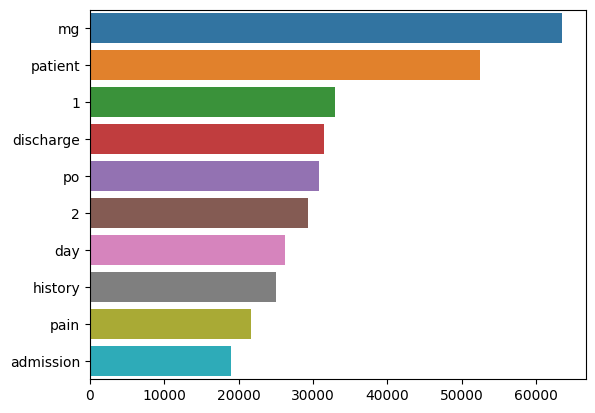

In [45]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

## Analyse des n-grams

### Bi-grams

In [13]:
BiVectorizer = CountVectorizer(ngram_range = (2, 2))
BiCorpus = BiVectorizer.fit_transform(df_corpus['rapport'].tolist())

In [ ]:
BiVectorizer.vocabulary_

In [15]:
# Obtenir les indices des éléments non nuls dans la matrice
non_zero_indices = BiCorpus.nonzero()

In [16]:
len(non_zero_indices[1])

3558197

In [38]:
non_zero_indices

(array([   0,    0,    0, ..., 6905, 6905, 6905], dtype=int32),
 array([125204, 267361,  50871, ..., 565700,   2206, 467552], dtype=int32))

In [42]:
len(BiCorpus.getrow(6905).toarray().flatten()[100000])

848479

In [21]:
# A revoir pour corriger les fréquences récupérées.
countBigrams = {}
i=0
for doc, word in zip(non_zero_indices[0].tolist(), non_zero_indices[1].tolist()):
    if i<5:
        # On vérifie si le mot est déjà dans le dictionnaire de fréquences :
        if list(BiVectorizer.vocabulary_.keys())[non_zero_indices[1][word]] in countBigrams:
            countBigrams[list(BiVectorizer.vocabulary_.keys())[non_zero_indices[1][word]]] += BiCorpus.getrow(non_zero_indices[0][doc]).toarray().flatten()[non_zero_indices[1][word]]
        else:
            # Si ce n'est pas le cas, on lui affecte juste la valeur contenue dans la matrice BiCorpus à la cellule correspondante.
            countBigrams[list(BiVectorizer.vocabulary_.keys())[non_zero_indices[1][word]]] = BiCorpus.getrow(non_zero_indices[0][doc]).toarray().flatten()[non_zero_indices[1][word]]
    else:
        break
    i+=1

In [22]:
countBigrams

{'markedly diminished': 0,
 'health cycle': 0,
 'contin try': 0,
 'region cystic': 0,
 'occasion sit': 0}

In [ ]:
# Génère une erreur du fait du remplissage de la mémoire RAM
count_values = BiCorpus.toarray().sum(axis=0)